# UB Pollution Forecast

Packages I used: 

In [66]:
import numpy as np 
import pandas as pd 
import xgboost
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import seaborn as sns


#### Importing data: 

In [67]:
test = pd.read_csv('test.csv')

In [68]:
X = pd.read_csv('X.csv')

In [69]:
y = pd.read_csv('y.csv')

In [70]:
weather  = pd.read_csv('weather.csv')

## Data Exploration and Cleaning 

Before cleaning data, I decided to figure out what kind of features are in the given data.

In [71]:
test.head()

,id,type,source,unit,date,value1,value2,value3
0,21158,PM2.5,Stateair.mn,µg/m3,2018-09-01 02:00:00,NaN,34.0,56.0
1,21159,PM2.5,Stateair.mn,µg/m3,2018-09-01 03:00:00,23.0,NaN,34.0
2,21160,PM2.5,Stateair.mn,µg/m3,2018-09-01 04:00:00,20.0,23.0,NaN
3,21161,PM2.5,Stateair.mn,µg/m3,2018-09-01 05:00:00,17.0,20.0,23.0
4,21162,PM2.5,Stateair.mn,µg/m3,2018-09-01 06:00:00,5.0,17.0,20.0


In [72]:
test.shape

(4536, 8)

In [73]:
X.head()

,id,type,source,unit,date,value1,value2,value3
0,0,PM2.5,Stateair.mn,µg/m3,2015-12-12 06:00:00,NaN,NaN,NaN
1,1,PM2.5,Stateair.mn,µg/m3,2015-12-12 07:00:00,242.0,NaN,NaN
2,2,PM2.5,Stateair.mn,µg/m3,2015-12-12 08:00:00,244.0,242.0,NaN
3,3,PM2.5,Stateair.mn,µg/m3,2015-12-12 09:00:00,93.0,244.0,242.0
4,4,PM2.5,Stateair.mn,µg/m3,2015-12-12 10:00:00,53.0,93.0,244.0


In [74]:
X.shape

(21157, 8)

In [75]:
y.head()

,id,value
0,0,242.0
1,1,244.0
2,2,93.0
3,3,53.0
4,4,64.0


In [76]:
y.shape

(21157, 2)

In [77]:
weather.head(4)

,time,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,visibility,ozone,precipType,precipAccumulation
0,1.449850e+09,Partly Cloudy,partly-cloudy-night,0.0,0.0,-19.72,-19.72,-22.99,0.75,NaN,0.0,NaN,NaN,NaN,0.44,0.0,10.003,NaN,NaN,NaN
1,1.449853e+09,Partly Cloudy,partly-cloudy-night,0.0,0.0,-19.72,-19.72,-22.01,0.82,NaN,1.0,NaN,NaN,NaN,0.44,0.0,10.003,NaN,NaN,NaN
2,1.449857e+09,Partly Cloudy,partly-cloudy-night,0.0,0.0,-19.65,-19.65,-21.96,0.82,1041.1,0.0,NaN,NaN,NaN,0.35,0.0,10.003,NaN,NaN,NaN
3,1.449860e+09,Partly Cloudy,partly-cloudy-night,0.0,0.0,-19.72,-19.72,-22.01,0.82,NaN,0.0,NaN,NaN,NaN,0.44,0.0,8.005,NaN,NaN,NaN


We have to convert the "time" feature to DateTime. Because we can't train data that has a timestamp feature.

In [78]:
weather['time'] = pd.to_datetime(weather['time'], unit='s')
weather = weather.rename(columns={"time":"date"})
X['date'] = pd.to_datetime(X['date'])

In [79]:
weather.dtypes

date                   datetime64[ns]
summary                        object
icon                           object
precipIntensity               float64
precipProbability             float64
temperature                   float64
apparentTemperature           float64
dewPoint                      float64
humidity                      float64
pressure                      float64
windSpeed                     float64
windGust                      float64
windGustTime                  float64
windBearing                   float64
cloudCover                    float64
uvIndex                       float64
visibility                    float64
ozone                         float64
precipType                     object
precipAccumulation            float64
dtype: object

In [80]:
X.dtypes

id                 int64
type              object
source            object
unit              object
date      datetime64[ns]
value1           float64
value2           float64
value3           float64
dtype: object

## Removing Outliers

In [81]:
X[['date','value1','value2','value3']].head()

,date,value1,value2,value3
0,2015-12-12 06:00:00,NaN,NaN,NaN
1,2015-12-12 07:00:00,242.0,NaN,NaN
2,2015-12-12 08:00:00,244.0,242.0,NaN
3,2015-12-12 09:00:00,93.0,244.0,242.0
4,2015-12-12 10:00:00,53.0,93.0,244.0


The best way to detect outliers is to demonstrate the data visually. So, I tried to see the outliers by using the line chart and box plot.

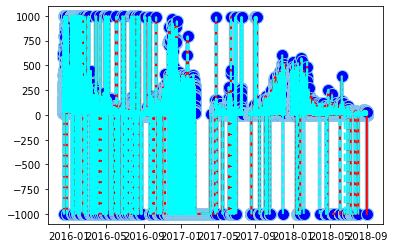

In [82]:
plt.plot( 'date', 'value1', data=X, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'date', 'value2', data=X, marker='', color='red', linewidth=2)
plt.plot( 'date', 'value3', data=X, marker='', color='cyan', linewidth=2, linestyle='dashed', label="toto")

plt.show()

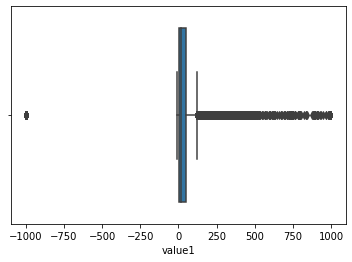

In [83]:
sns.boxplot(x=X['value1'])

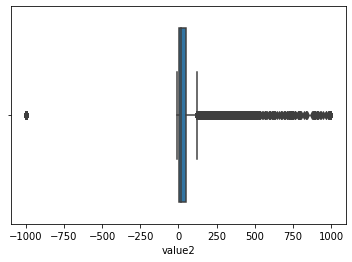

In [84]:
sns.boxplot(x=X['value2'])

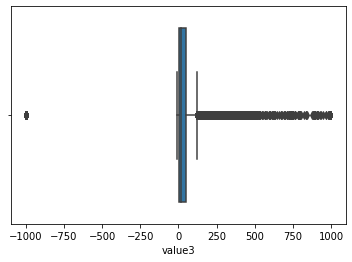

In [85]:
sns.boxplot(x=X['value3'])

As we can see from these box plots, most of the values are existing between 100 and 1000. So, I am planning to remove negative values. But we can't rid them manually. Because it was giving me an error: 
----------ValueError: Found input variables with inconsistent numbers of samples: [15593, 21157]
And, a teacher recommended me to use the "pd.clip()".It helps to keep the values within an upper and lower limit.

In [86]:
X[['value1','value2','value3']] = X[['value1','value2','value3']].clip(0,800)

In [87]:
X.head()

,id,type,source,unit,date,value1,value2,value3
0,0,PM2.5,Stateair.mn,µg/m3,2015-12-12 06:00:00,NaN,NaN,NaN
1,1,PM2.5,Stateair.mn,µg/m3,2015-12-12 07:00:00,242.0,NaN,NaN
2,2,PM2.5,Stateair.mn,µg/m3,2015-12-12 08:00:00,244.0,242.0,NaN
3,3,PM2.5,Stateair.mn,µg/m3,2015-12-12 09:00:00,93.0,244.0,242.0
4,4,PM2.5,Stateair.mn,µg/m3,2015-12-12 10:00:00,53.0,93.0,244.0


In [88]:
y[['value']] = y[['value']].clip(0,800)

In [89]:
y.head()

,id,value
0,0,242.0
1,1,244.0
2,2,93.0
3,3,53.0
4,4,64.0


In [90]:
weather.head()

,date,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,visibility,ozone,precipType,precipAccumulation
0,2015-12-11 16:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,-19.72,-19.72,-22.99,0.75,NaN,0.0,NaN,NaN,NaN,0.44,0.0,10.003,NaN,NaN,NaN
1,2015-12-11 17:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,-19.72,-19.72,-22.01,0.82,NaN,1.0,NaN,NaN,NaN,0.44,0.0,10.003,NaN,NaN,NaN
2,2015-12-11 18:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,-19.65,-19.65,-21.96,0.82,1041.1,0.0,NaN,NaN,NaN,0.35,0.0,10.003,NaN,NaN,NaN
3,2015-12-11 19:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,-19.72,-19.72,-22.01,0.82,NaN,0.0,NaN,NaN,NaN,0.44,0.0,8.005,NaN,NaN,NaN
4,2015-12-11 20:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,-19.72,-19.72,-22.01,0.82,NaN,0.0,NaN,NaN,NaN,0.44,0.0,6.004,NaN,NaN,NaN


## X = "weather" + "X"

In [91]:
X = pd.merge(X,weather,how = 'left', on = 'date')

In [92]:
X = X.drop(columns = ['precipIntensity','precipType','dewPoint','precipProbability','apparentTemperature','windSpeed','windGust','windBearing','cloudCover','uvIndex','ozone','precipAccumulation','summary','icon','windGustTime','type','source','unit'])

The reason why I merged these datasets is I thought some features of the weather dataset will be effective for model creation. In other words, the prediction result can be more accurate by adding features on the X set from weather set.

#### Creating previous value features by using Pandas Shift

I used the "shift" function in order to encode previous date data to new features

In [93]:
X['temperature_1'] = X.temperature.shift(periods=1)
X['humidity_1'] = X.humidity.shift(periods=1)
X['temperature_2'] = X.temperature.shift(periods=2)
X['humidity_2'] = X.humidity.shift(periods=2)
X['temperature_3'] = X.temperature.shift(periods=3)
X['humidity_3'] = X.humidity.shift(periods=3)
X['visibility_1'] = X.visibility.shift(periods=1)
X['visibility_2'] = X.visibility.shift(periods =2)
X['visibility_3'] = X.visibility.shift(periods = 3)
X['pressure1'] = X.pressure.shift(periods =1)
X['pressure2'] = X.pressure.shift(periods =2)
X['pressure3'] = X.pressure.shift(periods =3)

In [94]:
X.head()

,id,date,value1,value2,value3,temperature,humidity,pressure,visibility,temperature_1,...,temperature_2,humidity_2,temperature_3,humidity_3,visibility_1,visibility_2,visibility_3,pressure1,pressure2,pressure3
0,0,2015-12-12 06:00:00,NaN,NaN,NaN,-12.09,0.65,1035.8,2.997,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2015-12-12 07:00:00,242.0,NaN,NaN,-11.74,0.71,NaN,4.004,-12.09,...,NaN,NaN,NaN,NaN,2.997,NaN,NaN,1035.8,NaN,NaN
2,2,2015-12-12 08:00:00,244.0,242.0,NaN,-12.75,0.71,NaN,4.004,-11.74,...,-12.09,0.65,NaN,NaN,4.004,2.997,NaN,NaN,1035.8,NaN
3,3,2015-12-12 09:00:00,93.0,244.0,242.0,-15.23,0.74,1037.9,2.997,-12.75,...,-11.74,0.71,-12.09,0.65,4.004,4.004,2.997,NaN,NaN,1035.8
4,4,2015-12-12 10:00:00,53.0,93.0,244.0,-17.73,0.83,NaN,2.997,-15.23,...,-12.75,0.71,-11.74,0.71,2.997,4.004,4.004,1037.9,NaN,NaN


It is impossible to train the "DateTime".So, I want new columns showing year, month, hour, and day separately

In [95]:
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['hour'] = X['date'].dt.hour
X['day'] = X['date'].dt.day

In [96]:
X.head()

,id,date,value1,value2,value3,temperature,humidity,pressure,visibility,temperature_1,...,visibility_1,visibility_2,visibility_3,pressure1,pressure2,pressure3,year,month,hour,day
0,0,2015-12-12 06:00:00,NaN,NaN,NaN,-12.09,0.65,1035.8,2.997,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2015,12,6,12
1,1,2015-12-12 07:00:00,242.0,NaN,NaN,-11.74,0.71,NaN,4.004,-12.09,...,2.997,NaN,NaN,1035.8,NaN,NaN,2015,12,7,12
2,2,2015-12-12 08:00:00,244.0,242.0,NaN,-12.75,0.71,NaN,4.004,-11.74,...,4.004,2.997,NaN,NaN,1035.8,NaN,2015,12,8,12
3,3,2015-12-12 09:00:00,93.0,244.0,242.0,-15.23,0.74,1037.9,2.997,-12.75,...,4.004,4.004,2.997,NaN,NaN,1035.8,2015,12,9,12
4,4,2015-12-12 10:00:00,53.0,93.0,244.0,-17.73,0.83,NaN,2.997,-15.23,...,2.997,4.004,4.004,1037.9,NaN,NaN,2015,12,10,12


#### Handling NaNs

In [97]:
X = X.fillna(X.median())

In [98]:
X = X.drop(columns = ['date','id']).reset_index()

In [99]:
X.shape

(21157, 24)

In [100]:
y.shape

(21157, 2)

# Test set 

We won't use these objects ('type', 'source', 'unit')

In [101]:
test = test.drop(columns=['type', 'source', 'unit'])

In [102]:
test['date'] = pd.to_datetime(test['date'])

In [103]:
test = pd.merge(test ,weather,how = 'left', on = 'date')

In [104]:
test = test.drop(columns = ['precipIntensity','precipType','dewPoint','precipProbability','apparentTemperature','windSpeed','windGust','windBearing','cloudCover','uvIndex','ozone','precipAccumulation','summary','icon','windGustTime'])

In [105]:
test['temperature_1'] = test.temperature.shift(periods=1)
test['humidity_1'] = test.humidity.shift(periods=1)
test['temperature_2'] = test.temperature.shift(periods=2)
test['humidity_2'] =test.humidity.shift(periods=2)
test['temperature_3'] = test.temperature.shift(periods=3)
test['humidity_3'] = test.humidity.shift(periods=3)
test['visibility_1'] = test.visibility.shift(periods=1)
test['visibility_2'] = test.visibility.shift(periods=2)
test['visibility_3'] = test.visibility.shift(periods=3)
test['pressure1'] = test.pressure.shift(periods =1)
test['pressure2'] = test.pressure.shift(periods =2)
test['pressure3'] = test.pressure.shift(periods =3)

In [106]:
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['hour'] = test['date'].dt.hour
test['day'] = test['date'].dt.day

In [107]:
test = test.fillna(test.median())

In [108]:
test = test.drop(columns = ['date'])

In [109]:
test.head()

,id,value1,value2,value3,temperature,humidity,pressure,visibility,temperature_1,humidity_1,...,visibility_1,visibility_2,visibility_3,pressure1,pressure2,pressure3,year,month,hour,day
0,21158,47.0,34.0,56.0,16.39,0.75,1010.4,16.093,-9.77,0.46,...,16.093,16.093,16.093,1025.7,1025.7,1025.7,2018,9,2,1
1,21159,23.0,47.0,34.0,17.70,0.69,1009.7,16.093,16.39,0.75,...,16.093,16.093,16.093,1010.4,1025.7,1025.7,2018,9,3,1
2,21160,20.0,23.0,47.0,18.50,0.65,1008.2,16.093,17.70,0.69,...,16.093,16.093,16.093,1009.7,1010.4,1025.7,2018,9,4,1
3,21161,17.0,20.0,23.0,18.97,0.61,1007.2,16.093,18.50,0.65,...,16.093,16.093,16.093,1008.2,1009.7,1010.4,2018,9,5,1
4,21162,5.0,17.0,20.0,19.11,0.60,1007.1,16.093,18.97,0.61,...,16.093,16.093,16.093,1007.2,1008.2,1009.7,2018,9,6,1


In [110]:
test = test.set_index('id')

In [111]:
X = X.set_index('index')

In [112]:
y=y.set_index('id')

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Algorithms

### Decision Tree 

In [114]:
regressor = DecisionTreeRegressor(random_state = 42)

In [115]:
regressor.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [116]:
y_pred = regressor.predict(X_test)

In [117]:
np.sqrt(mean_squared_error(y_test, y_pred))

100.98138531226495

### Random Forest

In [118]:
clf = RandomForestRegressor(n_jobs= -1,
                           random_state = 42,
                           n_estimators = 2500, 
                           verbose = 10)

In [119]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 2500
building tree 2 of 2500
building tree 3 of 2500
building tree 4 of 2500
building tree 5 of 2500
building tree 6 of 2500
building tree 7 of 2500building tree 8 of 2500



[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


building tree 9 of 2500building tree 10 of 2500

building tree 11 of 2500
building tree 12 of 2500
building tree 13 of 2500
building tree 14 of 2500
building tree 15 of 2500
building tree 16 of 2500


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s


building tree 17 of 2500
building tree 18 of 2500
building tree 19 of 2500
building tree 20 of 2500
building tree 21 of 2500
building tree 22 of 2500
building tree 23 of 2500
building tree 24 of 2500
building tree 25 of 2500
building tree 26 of 2500
building tree 27 of 2500
building tree 28 of 2500
building tree 29 of 2500
building tree 30 of 2500
building tree 31 of 2500
building tree 32 of 2500


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s


building tree 33 of 2500
building tree 34 of 2500
building tree 35 of 2500
building tree 36 of 2500
building tree 37 of 2500
building tree 38 of 2500
building tree 39 of 2500
building tree 40 of 2500
building tree 41 of 2500
building tree 42 of 2500
building tree 43 of 2500
building tree 44 of 2500
building tree 45 of 2500
building tree 46 of 2500
building tree 47 of 2500
building tree 48 of 2500


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s


building tree 49 of 2500
building tree 50 of 2500building tree 51 of 2500

building tree 52 of 2500
building tree 53 of 2500
building tree 54 of 2500
building tree 55 of 2500
building tree 56 of 2500


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s


building tree 57 of 2500
building tree 58 of 2500
building tree 59 of 2500
building tree 60 of 2500
building tree 61 of 2500
building tree 62 of 2500
building tree 63 of 2500
building tree 64 of 2500


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s


building tree 65 of 2500
building tree 66 of 2500
building tree 67 of 2500
building tree 68 of 2500
building tree 69 of 2500
building tree 70 of 2500
building tree 71 of 2500
building tree 72 of 2500
building tree 73 of 2500
building tree 74 of 2500
building tree 75 of 2500
building tree 76 of 2500
building tree 77 of 2500
building tree 78 of 2500
building tree 79 of 2500


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.1s


building tree 80 of 2500
building tree 81 of 2500
building tree 82 of 2500
building tree 83 of 2500
building tree 84 of 2500
building tree 85 of 2500
building tree 86 of 2500
building tree 87 of 2500
building tree 88 of 2500
building tree 89 of 2500
building tree 90 of 2500
building tree 91 of 2500
building tree 92 of 2500building tree 93 of 2500

building tree 94 of 2500


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.5s


building tree 95 of 2500
building tree 96 of 2500
building tree 97 of 2500
building tree 98 of 2500
building tree 99 of 2500
building tree 100 of 2500
building tree 101 of 2500
building tree 102 of 2500
building tree 103 of 2500
building tree 104 of 2500
building tree 105 of 2500
building tree 106 of 2500
building tree 107 of 2500
building tree 108 of 2500


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    3.0s


building tree 109 of 2500
building tree 110 of 2500
building tree 111 of 2500
building tree 112 of 2500
building tree 113 of 2500
building tree 114 of 2500
building tree 115 of 2500
building tree 116 of 2500
building tree 117 of 2500
building tree 118 of 2500
building tree 119 of 2500
building tree 120 of 2500
building tree 121 of 2500
building tree 122 of 2500
building tree 123 of 2500
building tree 124 of 2500


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.4s


building tree 125 of 2500
building tree 126 of 2500
building tree 127 of 2500
building tree 128 of 2500
building tree 129 of 2500
building tree 130 of 2500
building tree 131 of 2500
building tree 132 of 2500
building tree 133 of 2500
building tree 134 of 2500
building tree 135 of 2500
building tree 136 of 2500
building tree 137 of 2500
building tree 138 of 2500
building tree 139 of 2500
building tree 140 of 2500


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    3.9s


building tree 141 of 2500
building tree 142 of 2500
building tree 143 of 2500
building tree 144 of 2500
building tree 145 of 2500
building tree 146 of 2500
building tree 147 of 2500
building tree 148 of 2500
building tree 149 of 2500
building tree 150 of 2500
building tree 151 of 2500
building tree 152 of 2500
building tree 153 of 2500
building tree 154 of 2500
building tree 155 of 2500
building tree 156 of 2500


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.4s


building tree 157 of 2500
building tree 158 of 2500
building tree 159 of 2500
building tree 160 of 2500
building tree 161 of 2500
building tree 162 of 2500
building tree 163 of 2500
building tree 164 of 2500
building tree 165 of 2500
building tree 166 of 2500
building tree 167 of 2500
building tree 168 of 2500
building tree 169 of 2500
building tree 170 of 2500
building tree 171 of 2500
building tree 172 of 2500


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    5.1s


building tree 173 of 2500
building tree 174 of 2500
building tree 175 of 2500
building tree 176 of 2500
building tree 177 of 2500
building tree 178 of 2500
building tree 179 of 2500
building tree 180 of 2500
building tree 181 of 2500
building tree 182 of 2500
building tree 183 of 2500
building tree 184 of 2500
building tree 185 of 2500
building tree 186 of 2500
building tree 187 of 2500
building tree 188 of 2500
building tree 189 of 2500
building tree 190 of 2500
building tree 191 of 2500
building tree 192 of 2500
building tree 193 of 2500
building tree 194 of 2500
building tree 195 of 2500


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.6s


building tree 196 of 2500
building tree 197 of 2500
building tree 198 of 2500
building tree 199 of 2500
building tree 200 of 2500
building tree 201 of 2500
building tree 202 of 2500
building tree 203 of 2500
building tree 204 of 2500
building tree 205 of 2500
building tree 206 of 2500
building tree 207 of 2500
building tree 208 of 2500
building tree 209 of 2500
building tree 210 of 2500
building tree 211 of 2500
building tree 212 of 2500
building tree 213 of 2500
building tree 214 of 2500
building tree 215 of 2500
building tree 216 of 2500


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    6.3s


building tree 217 of 2500
building tree 218 of 2500
building tree 219 of 2500
building tree 220 of 2500
building tree 221 of 2500
building tree 222 of 2500
building tree 223 of 2500
building tree 224 of 2500
building tree 225 of 2500
building tree 226 of 2500
building tree 227 of 2500
building tree 228 of 2500
building tree 229 of 2500
building tree 230 of 2500
building tree 231 of 2500
building tree 232 of 2500
building tree 233 of 2500
building tree 234 of 2500
building tree 235 of 2500
building tree 236 of 2500
building tree 237 of 2500
building tree 238 of 2500
building tree 239 of 2500


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    6.9s


building tree 240 of 2500
building tree 241 of 2500
building tree 242 of 2500
building tree 243 of 2500
building tree 244 of 2500
building tree 245 of 2500
building tree 246 of 2500
building tree 247 of 2500
building tree 248 of 2500
building tree 249 of 2500
building tree 250 of 2500
building tree 251 of 2500
building tree 252 of 2500
building tree 253 of 2500
building tree 254 of 2500
building tree 255 of 2500
building tree 256 of 2500
building tree 257 of 2500
building tree 258 of 2500
building tree 259 of 2500
building tree 260 of 2500


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    7.6s


building tree 261 of 2500
building tree 262 of 2500
building tree 263 of 2500
building tree 264 of 2500
building tree 265 of 2500
building tree 266 of 2500
building tree 267 of 2500
building tree 268 of 2500
building tree 269 of 2500
building tree 270 of 2500
building tree 271 of 2500
building tree 272 of 2500
building tree 273 of 2500
building tree 274 of 2500
building tree 275 of 2500
building tree 276 of 2500
building tree 277 of 2500
building tree 278 of 2500
building tree 279 of 2500
building tree 280 of 2500
building tree 281 of 2500
building tree 282 of 2500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    8.4s


building tree 283 of 2500
building tree 284 of 2500
building tree 285 of 2500
building tree 286 of 2500
building tree 287 of 2500
building tree 288 of 2500
building tree 289 of 2500
building tree 290 of 2500
building tree 291 of 2500
building tree 292 of 2500
building tree 293 of 2500
building tree 294 of 2500
building tree 295 of 2500
building tree 296 of 2500
building tree 297 of 2500
building tree 298 of 2500
building tree 299 of 2500
building tree 300 of 2500
building tree 301 of 2500
building tree 302 of 2500
building tree 303 of 2500
building tree 304 of 2500
building tree 305 of 2500
building tree 306 of 2500
building tree 307 of 2500
building tree 308 of 2500
building tree 309 of 2500
building tree 310 of 2500
building tree 311 of 2500


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:    9.2s


building tree 312 of 2500
building tree 313 of 2500
building tree 314 of 2500
building tree 315 of 2500
building tree 316 of 2500
building tree 317 of 2500
building tree 318 of 2500
building tree 319 of 2500
building tree 320 of 2500
building tree 321 of 2500
building tree 322 of 2500
building tree 323 of 2500
building tree 324 of 2500
building tree 325 of 2500
building tree 326 of 2500
building tree 327 of 2500
building tree 328 of 2500
building tree 329 of 2500
building tree 330 of 2500
building tree 331 of 2500
building tree 332 of 2500
building tree 333 of 2500
building tree 334 of 2500
building tree 335 of 2500


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   10.0s


building tree 336 of 2500
building tree 337 of 2500
building tree 338 of 2500
building tree 339 of 2500
building tree 340 of 2500
building tree 341 of 2500
building tree 342 of 2500
building tree 343 of 2500
building tree 344 of 2500
building tree 345 of 2500
building tree 346 of 2500
building tree 347 of 2500
building tree 348 of 2500
building tree 349 of 2500
building tree 350 of 2500
building tree 351 of 2500
building tree 352 of 2500
building tree 353 of 2500
building tree 354 of 2500
building tree 355 of 2500
building tree 356 of 2500
building tree 357 of 2500
building tree 358 of 2500
building tree 359 of 2500
building tree 360 of 2500
building tree 361 of 2500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.8s


building tree 362 of 2500
building tree 363 of 2500
building tree 364 of 2500
building tree 365 of 2500
building tree 366 of 2500
building tree 367 of 2500
building tree 368 of 2500
building tree 369 of 2500
building tree 370 of 2500
building tree 371 of 2500
building tree 372 of 2500
building tree 373 of 2500
building tree 374 of 2500
building tree 375 of 2500
building tree 376 of 2500
building tree 377 of 2500
building tree 378 of 2500
building tree 379 of 2500
building tree 380 of 2500
building tree 381 of 2500
building tree 382 of 2500
building tree 383 of 2500
building tree 384 of 2500
building tree 385 of 2500
building tree 386 of 2500
building tree 387 of 2500
building tree 388 of 2500


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   11.7s


building tree 389 of 2500
building tree 390 of 2500
building tree 391 of 2500
building tree 392 of 2500
building tree 393 of 2500
building tree 394 of 2500
building tree 395 of 2500
building tree 396 of 2500
building tree 397 of 2500
building tree 398 of 2500
building tree 399 of 2500
building tree 400 of 2500
building tree 401 of 2500
building tree 402 of 2500
building tree 403 of 2500
building tree 404 of 2500
building tree 405 of 2500
building tree 406 of 2500
building tree 407 of 2500
building tree 408 of 2500
building tree 409 of 2500
building tree 410 of 2500
building tree 411 of 2500
building tree 412 of 2500
building tree 413 of 2500
building tree 414 of 2500
building tree 415 of 2500
building tree 416 of 2500


[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   12.7s


building tree 417 of 2500
building tree 418 of 2500
building tree 419 of 2500
building tree 420 of 2500
building tree 421 of 2500
building tree 422 of 2500
building tree 423 of 2500
building tree 424 of 2500
building tree 425 of 2500
building tree 426 of 2500
building tree 427 of 2500
building tree 428 of 2500
building tree 429 of 2500
building tree 430 of 2500
building tree 431 of 2500
building tree 432 of 2500
building tree 433 of 2500
building tree 434 of 2500
building tree 435 of 2500
building tree 436 of 2500
building tree 437 of 2500
building tree 438 of 2500
building tree 439 of 2500
building tree 440 of 2500
building tree 441 of 2500
building tree 442 of 2500
building tree 443 of 2500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.6s


building tree 444 of 2500
building tree 445 of 2500
building tree 446 of 2500
building tree 447 of 2500
building tree 448 of 2500
building tree 449 of 2500
building tree 450 of 2500
building tree 451 of 2500
building tree 452 of 2500
building tree 453 of 2500
building tree 454 of 2500
building tree 455 of 2500
building tree 456 of 2500
building tree 457 of 2500
building tree 458 of 2500
building tree 459 of 2500
building tree 460 of 2500
building tree 461 of 2500
building tree 462 of 2500
building tree 463 of 2500
building tree 464 of 2500
building tree 465 of 2500
building tree 466 of 2500
building tree 467 of 2500
building tree 468 of 2500
building tree 469 of 2500
building tree 470 of 2500
building tree 471 of 2500
building tree 472 of 2500
building tree 473 of 2500


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:   14.5s


building tree 474 of 2500
building tree 475 of 2500
building tree 476 of 2500
building tree 477 of 2500
building tree 478 of 2500
building tree 479 of 2500
building tree 480 of 2500
building tree 481 of 2500
building tree 482 of 2500
building tree 483 of 2500
building tree 484 of 2500
building tree 485 of 2500
building tree 486 of 2500
building tree 487 of 2500
building tree 488 of 2500
building tree 489 of 2500
building tree 490 of 2500
building tree 491 of 2500
building tree 492 of 2500building tree 493 of 2500

building tree 494 of 2500
building tree 495 of 2500
building tree 496 of 2500
building tree 497 of 2500
building tree 498 of 2500
building tree 499 of 2500
building tree 500 of 2500
building tree 501 of 2500
building tree 502 of 2500
building tree 503 of 2500


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   15.4s


building tree 504 of 2500
building tree 505 of 2500
building tree 506 of 2500
building tree 507 of 2500
building tree 508 of 2500
building tree 509 of 2500
building tree 510 of 2500
building tree 511 of 2500
building tree 512 of 2500
building tree 513 of 2500
building tree 514 of 2500
building tree 515 of 2500
building tree 516 of 2500
building tree 517 of 2500
building tree 518 of 2500
building tree 519 of 2500
building tree 520 of 2500
building tree 521 of 2500
building tree 522 of 2500
building tree 523 of 2500
building tree 524 of 2500
building tree 525 of 2500
building tree 526 of 2500
building tree 527 of 2500
building tree 528 of 2500
building tree 529 of 2500
building tree 530 of 2500
building tree 531 of 2500
building tree 532 of 2500
building tree 533 of 2500
building tree 534 of 2500
building tree 535 of 2500
building tree 536 of 2500
building tree 537 of 2500
building tree 538 of 2500
building tree 539 of 2500
building tree 540 of 2500


[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:   16.4s


building tree 541 of 2500
building tree 542 of 2500
building tree 543 of 2500
building tree 544 of 2500
building tree 545 of 2500
building tree 546 of 2500
building tree 547 of 2500
building tree 548 of 2500
building tree 549 of 2500
building tree 550 of 2500
building tree 551 of 2500
building tree 552 of 2500
building tree 553 of 2500
building tree 554 of 2500
building tree 555 of 2500
building tree 556 of 2500
building tree 557 of 2500
building tree 558 of 2500
building tree 559 of 2500
building tree 560 of 2500
building tree 561 of 2500
building tree 562 of 2500
building tree 563 of 2500
building tree 564 of 2500
building tree 565 of 2500
building tree 566 of 2500
building tree 567 of 2500
building tree 568 of 2500
building tree 569 of 2500
building tree 570 of 2500


[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:   17.5s


building tree 571 of 2500
building tree 572 of 2500
building tree 573 of 2500
building tree 574 of 2500
building tree 575 of 2500
building tree 576 of 2500
building tree 577 of 2500
building tree 578 of 2500
building tree 579 of 2500
building tree 580 of 2500
building tree 581 of 2500
building tree 582 of 2500
building tree 583 of 2500
building tree 584 of 2500
building tree 585 of 2500
building tree 586 of 2500
building tree 587 of 2500
building tree 588 of 2500
building tree 589 of 2500
building tree 590 of 2500
building tree 591 of 2500
building tree 592 of 2500
building tree 593 of 2500
building tree 594 of 2500
building tree 595 of 2500
building tree 596 of 2500
building tree 597 of 2500
building tree 598 of 2500
building tree 599 of 2500
building tree 600 of 2500
building tree 601 of 2500
building tree 602 of 2500
building tree 603 of 2500
building tree 604 of 2500
building tree 605 of 2500
building tree 606 of 2500
building tree 607 of 2500
building tree 608 of 2500
building tre

[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   18.6s


building tree 611 of 2500
building tree 612 of 2500
building tree 613 of 2500building tree 614 of 2500

building tree 615 of 2500
building tree 616 of 2500
building tree 617 of 2500
building tree 618 of 2500
building tree 619 of 2500
building tree 620 of 2500
building tree 621 of 2500
building tree 622 of 2500
building tree 623 of 2500
building tree 624 of 2500
building tree 625 of 2500
building tree 626 of 2500
building tree 627 of 2500
building tree 628 of 2500
building tree 629 of 2500
building tree 630 of 2500
building tree 631 of 2500
building tree 632 of 2500
building tree 633 of 2500
building tree 634 of 2500
building tree 635 of 2500
building tree 636 of 2500
building tree 637 of 2500
building tree 638 of 2500
building tree 639 of 2500
building tree 640 of 2500
building tree 641 of 2500
building tree 642 of 2500
building tree 643 of 2500
building tree 644 of 2500


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   19.7s


building tree 645 of 2500
building tree 646 of 2500
building tree 647 of 2500
building tree 648 of 2500
building tree 649 of 2500
building tree 650 of 2500
building tree 651 of 2500
building tree 652 of 2500
building tree 653 of 2500
building tree 654 of 2500
building tree 655 of 2500
building tree 656 of 2500
building tree 657 of 2500
building tree 658 of 2500
building tree 659 of 2500
building tree 660 of 2500
building tree 661 of 2500
building tree 662 of 2500
building tree 663 of 2500
building tree 664 of 2500
building tree 665 of 2500
building tree 666 of 2500
building tree 667 of 2500
building tree 668 of 2500
building tree 669 of 2500
building tree 670 of 2500
building tree 671 of 2500
building tree 672 of 2500
building tree 673 of 2500
building tree 674 of 2500
building tree 675 of 2500
building tree 676 of 2500
building tree 677 of 2500
building tree 678 of 2500
building tree 679 of 2500


[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:   20.9s


building tree 680 of 2500
building tree 681 of 2500
building tree 682 of 2500
building tree 683 of 2500
building tree 684 of 2500
building tree 685 of 2500
building tree 686 of 2500
building tree 687 of 2500
building tree 688 of 2500
building tree 689 of 2500
building tree 690 of 2500
building tree 691 of 2500
building tree 692 of 2500
building tree 693 of 2500
building tree 694 of 2500
building tree 695 of 2500
building tree 696 of 2500
building tree 697 of 2500
building tree 698 of 2500
building tree 699 of 2500
building tree 700 of 2500
building tree 701 of 2500
building tree 702 of 2500
building tree 703 of 2500
building tree 704 of 2500
building tree 705 of 2500
building tree 706 of 2500
building tree 707 of 2500
building tree 708 of 2500
building tree 709 of 2500
building tree 710 of 2500
building tree 711 of 2500
building tree 712 of 2500
building tree 713 of 2500
building tree 714 of 2500
building tree 715 of 2500
building tree 716 of 2500
building tree 717 of 2500
building tre

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   22.0s


building tree 719 of 2500
building tree 720 of 2500
building tree 721 of 2500
building tree 722 of 2500
building tree 723 of 2500
building tree 724 of 2500
building tree 725 of 2500
building tree 726 of 2500
building tree 727 of 2500
building tree 728 of 2500
building tree 729 of 2500
building tree 730 of 2500
building tree 731 of 2500
building tree 732 of 2500
building tree 733 of 2500
building tree 734 of 2500
building tree 735 of 2500
building tree 736 of 2500
building tree 737 of 2500
building tree 738 of 2500
building tree 739 of 2500
building tree 740 of 2500
building tree 741 of 2500
building tree 742 of 2500
building tree 743 of 2500
building tree 744 of 2500
building tree 745 of 2500
building tree 746 of 2500
building tree 747 of 2500
building tree 748 of 2500
building tree 749 of 2500
building tree 750 of 2500
building tree 751 of 2500
building tree 752 of 2500
building tree 753 of 2500
building tree 754 of 2500
building tree 755 of 2500
building tree 756 of 2500


[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:   23.2s


building tree 757 of 2500
building tree 758 of 2500
building tree 759 of 2500
building tree 760 of 2500
building tree 761 of 2500
building tree 762 of 2500
building tree 763 of 2500
building tree 764 of 2500
building tree 765 of 2500
building tree 766 of 2500
building tree 767 of 2500
building tree 768 of 2500
building tree 769 of 2500
building tree 770 of 2500
building tree 771 of 2500
building tree 772 of 2500
building tree 773 of 2500
building tree 774 of 2500
building tree 775 of 2500
building tree 776 of 2500
building tree 777 of 2500
building tree 778 of 2500
building tree 779 of 2500
building tree 780 of 2500
building tree 781 of 2500
building tree 782 of 2500
building tree 783 of 2500
building tree 784 of 2500
building tree 785 of 2500
building tree 786 of 2500
building tree 787 of 2500
building tree 788 of 2500
building tree 789 of 2500
building tree 790 of 2500
building tree 791 of 2500


[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   24.4s


building tree 792 of 2500
building tree 793 of 2500
building tree 794 of 2500
building tree 795 of 2500
building tree 796 of 2500
building tree 797 of 2500
building tree 798 of 2500
building tree 799 of 2500
building tree 800 of 2500
building tree 801 of 2500
building tree 802 of 2500
building tree 803 of 2500
building tree 804 of 2500
building tree 805 of 2500
building tree 806 of 2500
building tree 807 of 2500building tree 808 of 2500

building tree 809 of 2500
building tree 810 of 2500
building tree 811 of 2500
building tree 812 of 2500
building tree 813 of 2500
building tree 814 of 2500
building tree 815 of 2500
building tree 816 of 2500
building tree 817 of 2500
building tree 818 of 2500
building tree 819 of 2500
building tree 820 of 2500
building tree 821 of 2500
building tree 822 of 2500
building tree 823 of 2500
building tree 824 of 2500
building tree 825 of 2500
building tree 826 of 2500
building tree 827 of 2500
building tree 828 of 2500
building tree 829 of 2500
building tre

[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:   25.6s


building tree 838 of 2500
building tree 839 of 2500
building tree 840 of 2500
building tree 841 of 2500
building tree 842 of 2500
building tree 843 of 2500
building tree 844 of 2500
building tree 845 of 2500
building tree 846 of 2500
building tree 847 of 2500
building tree 848 of 2500
building tree 849 of 2500
building tree 850 of 2500
building tree 851 of 2500
building tree 852 of 2500
building tree 853 of 2500
building tree 854 of 2500
building tree 855 of 2500
building tree 856 of 2500
building tree 857 of 2500
building tree 858 of 2500
building tree 859 of 2500
building tree 860 of 2500
building tree 861 of 2500
building tree 862 of 2500
building tree 863 of 2500
building tree 864 of 2500
building tree 865 of 2500
building tree 866 of 2500
building tree 867 of 2500
building tree 868 of 2500
building tree 869 of 2500
building tree 870 of 2500
building tree 871 of 2500
building tree 872 of 2500
building tree 873 of 2500
building tree 874 of 2500
building tree 875 of 2500
building tre

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   26.8s


building tree 878 of 2500
building tree 879 of 2500
building tree 880 of 2500
building tree 881 of 2500
building tree 882 of 2500
building tree 883 of 2500
building tree 884 of 2500
building tree 885 of 2500
building tree 886 of 2500
building tree 887 of 2500
building tree 888 of 2500
building tree 889 of 2500
building tree 890 of 2500
building tree 891 of 2500
building tree 892 of 2500
building tree 893 of 2500
building tree 894 of 2500
building tree 895 of 2500
building tree 896 of 2500
building tree 897 of 2500
building tree 898 of 2500
building tree 899 of 2500
building tree 900 of 2500
building tree 901 of 2500
building tree 902 of 2500
building tree 903 of 2500
building tree 904 of 2500
building tree 905 of 2500
building tree 906 of 2500
building tree 907 of 2500
building tree 908 of 2500
building tree 909 of 2500
building tree 910 of 2500
building tree 911 of 2500
building tree 912 of 2500
building tree 913 of 2500
building tree 914 of 2500
building tree 915 of 2500
building tre

[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:   28.1s


building tree 922 of 2500
building tree 923 of 2500
building tree 924 of 2500
building tree 925 of 2500
building tree 926 of 2500
building tree 927 of 2500
building tree 928 of 2500
building tree 929 of 2500
building tree 930 of 2500
building tree 931 of 2500
building tree 932 of 2500
building tree 933 of 2500
building tree 934 of 2500
building tree 935 of 2500
building tree 936 of 2500
building tree 937 of 2500
building tree 938 of 2500
building tree 939 of 2500
building tree 940 of 2500
building tree 941 of 2500
building tree 942 of 2500
building tree 943 of 2500
building tree 944 of 2500
building tree 945 of 2500
building tree 946 of 2500
building tree 947 of 2500
building tree 948 of 2500
building tree 949 of 2500
building tree 950 of 2500
building tree 951 of 2500
building tree 952 of 2500
building tree 953 of 2500
building tree 954 of 2500
building tree 955 of 2500
building tree 956 of 2500
building tree 957 of 2500
building tree 958 of 2500
building tree 959 of 2500
building tre

[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   29.5s


building tree 966 of 2500
building tree 967 of 2500
building tree 968 of 2500
building tree 969 of 2500
building tree 970 of 2500
building tree 971 of 2500
building tree 972 of 2500
building tree 973 of 2500
building tree 974 of 2500
building tree 975 of 2500
building tree 976 of 2500
building tree 977 of 2500
building tree 978 of 2500
building tree 979 of 2500
building tree 980 of 2500
building tree 981 of 2500
building tree 982 of 2500
building tree 983 of 2500
building tree 984 of 2500
building tree 985 of 2500
building tree 986 of 2500
building tree 987 of 2500
building tree 988 of 2500
building tree 989 of 2500
building tree 990 of 2500
building tree 991 of 2500
building tree 992 of 2500
building tree 993 of 2500
building tree 994 of 2500
building tree 995 of 2500
building tree 996 of 2500
building tree 997 of 2500
building tree 998 of 2500building tree 999 of 2500

building tree 1000 of 2500
building tree 1001 of 2500
building tree 1002 of 2500
building tree 1003 of 2500
building

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   30.9s


building tree 1008 of 2500
building tree 1009 of 2500
building tree 1010 of 2500
building tree 1011 of 2500
building tree 1012 of 2500
building tree 1013 of 2500
building tree 1014 of 2500
building tree 1015 of 2500
building tree 1016 of 2500
building tree 1017 of 2500
building tree 1018 of 2500
building tree 1019 of 2500
building tree 1020 of 2500
building tree 1021 of 2500
building tree 1022 of 2500
building tree 1023 of 2500
building tree 1024 of 2500
building tree 1025 of 2500
building tree 1026 of 2500
building tree 1027 of 2500
building tree 1028 of 2500
building tree 1029 of 2500
building tree 1030 of 2500
building tree 1031 of 2500
building tree 1032 of 2500
building tree 1033 of 2500
building tree 1034 of 2500
building tree 1035 of 2500
building tree 1036 of 2500
building tree 1037 of 2500
building tree 1038 of 2500
building tree 1039 of 2500
building tree 1040 of 2500
building tree 1041 of 2500
building tree 1042 of 2500
building tree 1043 of 2500
building tree 1044 of 2500
b

[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed:   32.3s


building tree 1051 of 2500
building tree 1052 of 2500
building tree 1053 of 2500
building tree 1054 of 2500
building tree 1055 of 2500
building tree 1056 of 2500
building tree 1057 of 2500
building tree 1058 of 2500
building tree 1059 of 2500
building tree 1060 of 2500
building tree 1061 of 2500
building tree 1062 of 2500
building tree 1063 of 2500
building tree 1064 of 2500
building tree 1065 of 2500
building tree 1066 of 2500
building tree 1067 of 2500
building tree 1068 of 2500
building tree 1069 of 2500
building tree 1070 of 2500
building tree 1071 of 2500
building tree 1072 of 2500
building tree 1073 of 2500
building tree 1074 of 2500
building tree 1075 of 2500
building tree 1076 of 2500
building tree 1077 of 2500
building tree 1078 of 2500
building tree 1079 of 2500
building tree 1080 of 2500
building tree 1081 of 2500
building tree 1082 of 2500
building tree 1083 of 2500
building tree 1084 of 2500
building tree 1085 of 2500
building tree 1086 of 2500
building tree 1087 of 2500
b

[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed:   33.8s


building tree 1102 of 2500
building tree 1103 of 2500
building tree 1104 of 2500
building tree 1105 of 2500
building tree 1106 of 2500
building tree 1107 of 2500
building tree 1108 of 2500
building tree 1109 of 2500
building tree 1110 of 2500
building tree 1111 of 2500
building tree 1112 of 2500
building tree 1113 of 2500
building tree 1114 of 2500
building tree 1115 of 2500
building tree 1116 of 2500
building tree 1117 of 2500
building tree 1118 of 2500
building tree 1119 of 2500
building tree 1120 of 2500
building tree 1121 of 2500
building tree 1122 of 2500
building tree 1123 of 2500
building tree 1124 of 2500
building tree 1125 of 2500
building tree 1126 of 2500
building tree 1127 of 2500
building tree 1128 of 2500
building tree 1129 of 2500
building tree 1130 of 2500
building tree 1131 of 2500
building tree 1132 of 2500
building tree 1133 of 2500
building tree 1134 of 2500
building tree 1135 of 2500
building tree 1136 of 2500
building tree 1137 of 2500
building tree 1138 of 2500
b

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   35.3s


building tree 1148 of 2500
building tree 1149 of 2500
building tree 1150 of 2500
building tree 1151 of 2500
building tree 1152 of 2500
building tree 1153 of 2500
building tree 1154 of 2500
building tree 1155 of 2500
building tree 1156 of 2500
building tree 1157 of 2500
building tree 1158 of 2500
building tree 1159 of 2500
building tree 1160 of 2500
building tree 1161 of 2500
building tree 1162 of 2500
building tree 1163 of 2500
building tree 1164 of 2500
building tree 1165 of 2500
building tree 1166 of 2500
building tree 1167 of 2500building tree 1168 of 2500

building tree 1169 of 2500
building tree 1170 of 2500
building tree 1171 of 2500
building tree 1172 of 2500
building tree 1173 of 2500
building tree 1174 of 2500
building tree 1175 of 2500
building tree 1176 of 2500
building tree 1177 of 2500
building tree 1178 of 2500
building tree 1179 of 2500
building tree 1180 of 2500
building tree 1181 of 2500building tree 1182 of 2500

building tree 1183 of 2500
building tree 1184 of 2500
b

[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:   36.8s


building tree 1194 of 2500
building tree 1195 of 2500
building tree 1196 of 2500
building tree 1197 of 2500
building tree 1198 of 2500
building tree 1199 of 2500
building tree 1200 of 2500
building tree 1201 of 2500
building tree 1202 of 2500
building tree 1203 of 2500
building tree 1204 of 2500
building tree 1205 of 2500
building tree 1206 of 2500
building tree 1207 of 2500
building tree 1208 of 2500
building tree 1209 of 2500
building tree 1210 of 2500
building tree 1211 of 2500
building tree 1212 of 2500
building tree 1213 of 2500
building tree 1214 of 2500
building tree 1215 of 2500
building tree 1216 of 2500
building tree 1217 of 2500
building tree 1218 of 2500
building tree 1219 of 2500
building tree 1220 of 2500
building tree 1221 of 2500
building tree 1222 of 2500
building tree 1223 of 2500
building tree 1224 of 2500
building tree 1225 of 2500
building tree 1226 of 2500
building tree 1227 of 2500
building tree 1228 of 2500
building tree 1229 of 2500
building tree 1230 of 2500
b

[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   38.3s


building tree 1247 of 2500
building tree 1248 of 2500
building tree 1249 of 2500
building tree 1250 of 2500
building tree 1251 of 2500
building tree 1252 of 2500
building tree 1253 of 2500
building tree 1254 of 2500
building tree 1255 of 2500
building tree 1256 of 2500
building tree 1257 of 2500
building tree 1258 of 2500
building tree 1259 of 2500
building tree 1260 of 2500
building tree 1261 of 2500
building tree 1262 of 2500
building tree 1263 of 2500
building tree 1264 of 2500
building tree 1265 of 2500
building tree 1266 of 2500
building tree 1267 of 2500
building tree 1268 of 2500
building tree 1269 of 2500
building tree 1270 of 2500
building tree 1271 of 2500
building tree 1272 of 2500
building tree 1273 of 2500
building tree 1274 of 2500
building tree 1275 of 2500
building tree 1276 of 2500
building tree 1277 of 2500
building tree 1278 of 2500
building tree 1279 of 2500
building tree 1280 of 2500
building tree 1281 of 2500
building tree 1282 of 2500
building tree 1283 of 2500
b

[Parallel(n_jobs=-1)]: Done 1285 tasks      | elapsed:   39.8s


building tree 1299 of 2500
building tree 1300 of 2500
building tree 1301 of 2500
building tree 1302 of 2500
building tree 1303 of 2500
building tree 1304 of 2500
building tree 1305 of 2500
building tree 1306 of 2500
building tree 1307 of 2500
building tree 1308 of 2500
building tree 1309 of 2500
building tree 1310 of 2500
building tree 1311 of 2500
building tree 1312 of 2500
building tree 1313 of 2500
building tree 1314 of 2500
building tree 1315 of 2500
building tree 1316 of 2500
building tree 1317 of 2500
building tree 1318 of 2500
building tree 1319 of 2500
building tree 1320 of 2500
building tree 1321 of 2500
building tree 1322 of 2500
building tree 1323 of 2500
building tree 1324 of 2500
building tree 1325 of 2500
building tree 1326 of 2500
building tree 1327 of 2500
building tree 1328 of 2500
building tree 1329 of 2500building tree 1330 of 2500

building tree 1331 of 2500
building tree 1332 of 2500
building tree 1333 of 2500
building tree 1334 of 2500
building tree 1335 of 2500
b

[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:   41.4s


building tree 1344 of 2500
building tree 1345 of 2500
building tree 1346 of 2500
building tree 1347 of 2500
building tree 1348 of 2500
building tree 1349 of 2500
building tree 1350 of 2500
building tree 1351 of 2500
building tree 1352 of 2500
building tree 1353 of 2500
building tree 1354 of 2500
building tree 1355 of 2500
building tree 1356 of 2500
building tree 1357 of 2500
building tree 1358 of 2500
building tree 1359 of 2500
building tree 1360 of 2500
building tree 1361 of 2500
building tree 1362 of 2500
building tree 1363 of 2500
building tree 1364 of 2500
building tree 1365 of 2500
building tree 1366 of 2500
building tree 1367 of 2500
building tree 1368 of 2500
building tree 1369 of 2500
building tree 1370 of 2500
building tree 1371 of 2500
building tree 1372 of 2500
building tree 1373 of 2500
building tree 1374 of 2500
building tree 1375 of 2500
building tree 1376 of 2500
building tree 1377 of 2500
building tree 1378 of 2500
building tree 1379 of 2500
building tree 1380 of 2500
b

[Parallel(n_jobs=-1)]: Done 1389 tasks      | elapsed:   42.9s


building tree 1398 of 2500
building tree 1399 of 2500
building tree 1400 of 2500
building tree 1401 of 2500
building tree 1402 of 2500
building tree 1403 of 2500
building tree 1404 of 2500
building tree 1405 of 2500
building tree 1406 of 2500
building tree 1407 of 2500
building tree 1408 of 2500
building tree 1409 of 2500
building tree 1410 of 2500
building tree 1411 of 2500
building tree 1412 of 2500
building tree 1413 of 2500
building tree 1414 of 2500
building tree 1415 of 2500
building tree 1416 of 2500
building tree 1417 of 2500
building tree 1418 of 2500
building tree 1419 of 2500
building tree 1420 of 2500
building tree 1421 of 2500
building tree 1422 of 2500
building tree 1423 of 2500
building tree 1424 of 2500
building tree 1425 of 2500
building tree 1426 of 2500
building tree 1427 of 2500
building tree 1428 of 2500
building tree 1429 of 2500
building tree 1430 of 2500
building tree 1431 of 2500
building tree 1432 of 2500
building tree 1433 of 2500
building tree 1434 of 2500
b

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   44.5s


building tree 1452 of 2500
building tree 1453 of 2500
building tree 1454 of 2500
building tree 1455 of 2500
building tree 1456 of 2500
building tree 1457 of 2500
building tree 1458 of 2500
building tree 1459 of 2500
building tree 1460 of 2500
building tree 1461 of 2500
building tree 1462 of 2500
building tree 1463 of 2500
building tree 1464 of 2500
building tree 1465 of 2500
building tree 1466 of 2500
building tree 1467 of 2500
building tree 1468 of 2500
building tree 1469 of 2500
building tree 1470 of 2500
building tree 1471 of 2500
building tree 1472 of 2500
building tree 1473 of 2500
building tree 1474 of 2500
building tree 1475 of 2500
building tree 1476 of 2500
building tree 1477 of 2500
building tree 1478 of 2500
building tree 1479 of 2500
building tree 1480 of 2500
building tree 1481 of 2500
building tree 1482 of 2500
building tree 1483 of 2500
building tree 1484 of 2500
building tree 1485 of 2500
building tree 1486 of 2500
building tree 1487 of 2500
building tree 1488 of 2500
b

[Parallel(n_jobs=-1)]: Done 1497 tasks      | elapsed:   46.4s


building tree 1510 of 2500
building tree 1511 of 2500
building tree 1512 of 2500
building tree 1513 of 2500
building tree 1514 of 2500
building tree 1515 of 2500
building tree 1516 of 2500
building tree 1517 of 2500
building tree 1518 of 2500
building tree 1519 of 2500
building tree 1520 of 2500
building tree 1521 of 2500
building tree 1522 of 2500
building tree 1523 of 2500
building tree 1524 of 2500
building tree 1525 of 2500
building tree 1526 of 2500
building tree 1527 of 2500
building tree 1528 of 2500
building tree 1529 of 2500
building tree 1530 of 2500
building tree 1531 of 2500
building tree 1532 of 2500
building tree 1533 of 2500
building tree 1534 of 2500
building tree 1535 of 2500
building tree 1536 of 2500
building tree 1537 of 2500
building tree 1538 of 2500
building tree 1539 of 2500
building tree 1540 of 2500
building tree 1541 of 2500
building tree 1542 of 2500
building tree 1543 of 2500
building tree 1544 of 2500
building tree 1545 of 2500
building tree 1546 of 2500
b

[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   48.1s


building tree 1561 of 2500
building tree 1562 of 2500
building tree 1563 of 2500
building tree 1564 of 2500
building tree 1565 of 2500
building tree 1566 of 2500
building tree 1567 of 2500
building tree 1568 of 2500
building tree 1569 of 2500
building tree 1570 of 2500building tree 1571 of 2500

building tree 1572 of 2500
building tree 1573 of 2500
building tree 1574 of 2500
building tree 1575 of 2500
building tree 1576 of 2500
building tree 1577 of 2500
building tree 1578 of 2500
building tree 1579 of 2500
building tree 1580 of 2500
building tree 1581 of 2500
building tree 1582 of 2500
building tree 1583 of 2500
building tree 1584 of 2500
building tree 1585 of 2500
building tree 1586 of 2500
building tree 1587 of 2500
building tree 1588 of 2500
building tree 1589 of 2500
building tree 1590 of 2500
building tree 1591 of 2500
building tree 1592 of 2500
building tree 1593 of 2500
building tree 1594 of 2500
building tree 1595 of 2500
building tree 1596 of 2500
building tree 1597 of 2500
b

[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed:   49.8s


building tree 1622 of 2500
building tree 1623 of 2500
building tree 1624 of 2500
building tree 1625 of 2500
building tree 1626 of 2500
building tree 1627 of 2500
building tree 1628 of 2500
building tree 1629 of 2500
building tree 1630 of 2500
building tree 1631 of 2500
building tree 1632 of 2500
building tree 1633 of 2500
building tree 1634 of 2500
building tree 1635 of 2500
building tree 1636 of 2500
building tree 1637 of 2500
building tree 1638 of 2500
building tree 1639 of 2500
building tree 1640 of 2500
building tree 1641 of 2500
building tree 1642 of 2500
building tree 1643 of 2500
building tree 1644 of 2500
building tree 1645 of 2500
building tree 1646 of 2500
building tree 1647 of 2500
building tree 1648 of 2500
building tree 1649 of 2500
building tree 1650 of 2500
building tree 1651 of 2500
building tree 1652 of 2500
building tree 1653 of 2500
building tree 1654 of 2500
building tree 1655 of 2500
building tree 1656 of 2500
building tree 1657 of 2500
building tree 1658 of 2500
b

[Parallel(n_jobs=-1)]: Done 1666 tasks      | elapsed:   51.5s


building tree 1676 of 2500
building tree 1677 of 2500
building tree 1678 of 2500
building tree 1679 of 2500
building tree 1680 of 2500
building tree 1681 of 2500
building tree 1682 of 2500
building tree 1683 of 2500
building tree 1684 of 2500
building tree 1685 of 2500
building tree 1686 of 2500
building tree 1687 of 2500
building tree 1688 of 2500
building tree 1689 of 2500
building tree 1690 of 2500
building tree 1691 of 2500
building tree 1692 of 2500
building tree 1693 of 2500
building tree 1694 of 2500
building tree 1695 of 2500
building tree 1696 of 2500
building tree 1697 of 2500
building tree 1698 of 2500
building tree 1699 of 2500
building tree 1700 of 2500
building tree 1701 of 2500
building tree 1702 of 2500
building tree 1703 of 2500
building tree 1704 of 2500
building tree 1705 of 2500
building tree 1706 of 2500
building tree 1707 of 2500
building tree 1708 of 2500
building tree 1709 of 2500
building tree 1710 of 2500
building tree 1711 of 2500
building tree 1712 of 2500
b

[Parallel(n_jobs=-1)]: Done 1725 tasks      | elapsed:   53.2s


building tree 1734 of 2500
building tree 1735 of 2500
building tree 1736 of 2500
building tree 1737 of 2500
building tree 1738 of 2500
building tree 1739 of 2500
building tree 1740 of 2500
building tree 1741 of 2500
building tree 1742 of 2500
building tree 1743 of 2500
building tree 1744 of 2500
building tree 1745 of 2500
building tree 1746 of 2500
building tree 1747 of 2500
building tree 1748 of 2500
building tree 1749 of 2500
building tree 1750 of 2500
building tree 1751 of 2500
building tree 1752 of 2500
building tree 1753 of 2500
building tree 1754 of 2500
building tree 1755 of 2500
building tree 1756 of 2500
building tree 1757 of 2500
building tree 1758 of 2500
building tree 1759 of 2500
building tree 1760 of 2500
building tree 1761 of 2500
building tree 1762 of 2500
building tree 1763 of 2500
building tree 1764 of 2500
building tree 1765 of 2500
building tree 1766 of 2500
building tree 1767 of 2500
building tree 1768 of 2500
building tree 1769 of 2500
building tree 1770 of 2500
b

[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   54.9s


building tree 1796 of 2500
building tree 1797 of 2500
building tree 1798 of 2500
building tree 1799 of 2500
building tree 1800 of 2500
building tree 1801 of 2500
building tree 1802 of 2500
building tree 1803 of 2500
building tree 1804 of 2500
building tree 1805 of 2500
building tree 1806 of 2500
building tree 1807 of 2500
building tree 1808 of 2500
building tree 1809 of 2500
building tree 1810 of 2500
building tree 1811 of 2500
building tree 1812 of 2500
building tree 1813 of 2500
building tree 1814 of 2500
building tree 1815 of 2500
building tree 1816 of 2500
building tree 1817 of 2500
building tree 1818 of 2500
building tree 1819 of 2500
building tree 1820 of 2500
building tree 1821 of 2500
building tree 1822 of 2500
building tree 1823 of 2500
building tree 1824 of 2500
building tree 1825 of 2500
building tree 1826 of 2500
building tree 1827 of 2500
building tree 1828 of 2500
building tree 1829 of 2500
building tree 1830 of 2500
building tree 1831 of 2500
building tree 1832 of 2500
b

[Parallel(n_jobs=-1)]: Done 1845 tasks      | elapsed:   56.7s


building tree 1859 of 2500
building tree 1860 of 2500
building tree 1861 of 2500
building tree 1862 of 2500
building tree 1863 of 2500
building tree 1864 of 2500
building tree 1865 of 2500
building tree 1866 of 2500
building tree 1867 of 2500
building tree 1868 of 2500
building tree 1869 of 2500
building tree 1870 of 2500
building tree 1871 of 2500
building tree 1872 of 2500
building tree 1873 of 2500
building tree 1874 of 2500
building tree 1875 of 2500
building tree 1876 of 2500
building tree 1877 of 2500
building tree 1878 of 2500
building tree 1879 of 2500
building tree 1880 of 2500
building tree 1881 of 2500
building tree 1882 of 2500
building tree 1883 of 2500
building tree 1884 of 2500
building tree 1885 of 2500
building tree 1886 of 2500
building tree 1887 of 2500
building tree 1888 of 2500
building tree 1889 of 2500
building tree 1890 of 2500
building tree 1891 of 2500
building tree 1892 of 2500
building tree 1893 of 2500
building tree 1894 of 2500
building tree 1895 of 2500
b

[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed:   58.7s


building tree 1921 of 2500
building tree 1922 of 2500
building tree 1923 of 2500
building tree 1924 of 2500
building tree 1925 of 2500
building tree 1926 of 2500
building tree 1927 of 2500
building tree 1928 of 2500
building tree 1929 of 2500
building tree 1930 of 2500
building tree 1931 of 2500
building tree 1932 of 2500
building tree 1933 of 2500
building tree 1934 of 2500
building tree 1935 of 2500
building tree 1936 of 2500
building tree 1937 of 2500
building tree 1938 of 2500
building tree 1939 of 2500
building tree 1940 of 2500
building tree 1941 of 2500
building tree 1942 of 2500
building tree 1943 of 2500
building tree 1944 of 2500
building tree 1945 of 2500
building tree 1946 of 2500
building tree 1947 of 2500
building tree 1948 of 2500
building tree 1949 of 2500
building tree 1950 of 2500
building tree 1951 of 2500
building tree 1952 of 2500
building tree 1953 of 2500
building tree 1954 of 2500
building tree 1955 of 2500
building tree 1956 of 2500
building tree 1957 of 2500
b

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.0min


building tree 1984 of 2500
building tree 1985 of 2500
building tree 1986 of 2500
building tree 1987 of 2500
building tree 1988 of 2500
building tree 1989 of 2500
building tree 1990 of 2500
building tree 1991 of 2500
building tree 1992 of 2500
building tree 1993 of 2500
building tree 1994 of 2500
building tree 1995 of 2500
building tree 1996 of 2500
building tree 1997 of 2500
building tree 1998 of 2500
building tree 1999 of 2500
building tree 2000 of 2500
building tree 2001 of 2500
building tree 2002 of 2500
building tree 2003 of 2500
building tree 2004 of 2500
building tree 2005 of 2500
building tree 2006 of 2500
building tree 2007 of 2500
building tree 2008 of 2500
building tree 2009 of 2500
building tree 2010 of 2500
building tree 2011 of 2500
building tree 2012 of 2500
building tree 2013 of 2500
building tree 2014 of 2500
building tree 2015 of 2500
building tree 2016 of 2500
building tree 2017 of 2500
building tree 2018 of 2500
building tree 2019 of 2500
building tree 2020 of 2500
b

[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  1.0min


building tree 2044 of 2500
building tree 2045 of 2500
building tree 2046 of 2500
building tree 2047 of 2500
building tree 2048 of 2500
building tree 2049 of 2500
building tree 2050 of 2500
building tree 2051 of 2500
building tree 2052 of 2500
building tree 2053 of 2500
building tree 2054 of 2500
building tree 2055 of 2500
building tree 2056 of 2500
building tree 2057 of 2500
building tree 2058 of 2500
building tree 2059 of 2500
building tree 2060 of 2500
building tree 2061 of 2500
building tree 2062 of 2500
building tree 2063 of 2500
building tree 2064 of 2500
building tree 2065 of 2500
building tree 2066 of 2500
building tree 2067 of 2500
building tree 2068 of 2500
building tree 2069 of 2500
building tree 2070 of 2500
building tree 2071 of 2500
building tree 2072 of 2500
building tree 2073 of 2500
building tree 2074 of 2500
building tree 2075 of 2500
building tree 2076 of 2500
building tree 2077 of 2500
building tree 2078 of 2500
building tree 2079 of 2500
building tree 2080 of 2500
b

[Parallel(n_jobs=-1)]: Done 2097 tasks      | elapsed:  1.1min


building tree 2107 of 2500
building tree 2108 of 2500
building tree 2109 of 2500
building tree 2110 of 2500
building tree 2111 of 2500
building tree 2112 of 2500
building tree 2113 of 2500
building tree 2114 of 2500
building tree 2115 of 2500
building tree 2116 of 2500
building tree 2117 of 2500
building tree 2118 of 2500
building tree 2119 of 2500
building tree 2120 of 2500
building tree 2121 of 2500
building tree 2122 of 2500
building tree 2123 of 2500
building tree 2124 of 2500
building tree 2125 of 2500
building tree 2126 of 2500
building tree 2127 of 2500
building tree 2128 of 2500
building tree 2129 of 2500
building tree 2130 of 2500
building tree 2131 of 2500
building tree 2132 of 2500
building tree 2133 of 2500
building tree 2134 of 2500
building tree 2135 of 2500
building tree 2136 of 2500
building tree 2137 of 2500
building tree 2138 of 2500
building tree 2139 of 2500
building tree 2140 of 2500
building tree 2141 of 2500
building tree 2142 of 2500
building tree 2143 of 2500
b

[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  1.1min


building tree 2174 of 2500
building tree 2175 of 2500
building tree 2176 of 2500
building tree 2177 of 2500
building tree 2178 of 2500
building tree 2179 of 2500
building tree 2180 of 2500
building tree 2181 of 2500
building tree 2182 of 2500
building tree 2183 of 2500
building tree 2184 of 2500
building tree 2185 of 2500
building tree 2186 of 2500
building tree 2187 of 2500
building tree 2188 of 2500
building tree 2189 of 2500
building tree 2190 of 2500
building tree 2191 of 2500
building tree 2192 of 2500
building tree 2193 of 2500
building tree 2194 of 2500
building tree 2195 of 2500
building tree 2196 of 2500
building tree 2197 of 2500
building tree 2198 of 2500
building tree 2199 of 2500
building tree 2200 of 2500
building tree 2201 of 2500
building tree 2202 of 2500
building tree 2203 of 2500
building tree 2204 of 2500
building tree 2205 of 2500
building tree 2206 of 2500
building tree 2207 of 2500
building tree 2208 of 2500
building tree 2209 of 2500
building tree 2210 of 2500
b

[Parallel(n_jobs=-1)]: Done 2229 tasks      | elapsed:  1.1min


building tree 2241 of 2500
building tree 2242 of 2500
building tree 2243 of 2500
building tree 2244 of 2500
building tree 2245 of 2500
building tree 2246 of 2500
building tree 2247 of 2500
building tree 2248 of 2500
building tree 2249 of 2500
building tree 2250 of 2500
building tree 2251 of 2500building tree 2252 of 2500

building tree 2253 of 2500
building tree 2254 of 2500
building tree 2255 of 2500
building tree 2256 of 2500
building tree 2257 of 2500
building tree 2258 of 2500
building tree 2259 of 2500
building tree 2260 of 2500
building tree 2261 of 2500
building tree 2262 of 2500
building tree 2263 of 2500
building tree 2264 of 2500
building tree 2265 of 2500
building tree 2266 of 2500
building tree 2267 of 2500
building tree 2268 of 2500
building tree 2269 of 2500
building tree 2270 of 2500
building tree 2271 of 2500
building tree 2272 of 2500
building tree 2273 of 2500
building tree 2274 of 2500
building tree 2275 of 2500
building tree 2276 of 2500
building tree 2277 of 2500
b

[Parallel(n_jobs=-1)]: Done 2296 tasks      | elapsed:  1.2min


building tree 2309 of 2500
building tree 2310 of 2500
building tree 2311 of 2500
building tree 2312 of 2500
building tree 2313 of 2500
building tree 2314 of 2500
building tree 2315 of 2500
building tree 2316 of 2500
building tree 2317 of 2500
building tree 2318 of 2500
building tree 2319 of 2500
building tree 2320 of 2500
building tree 2321 of 2500
building tree 2322 of 2500
building tree 2323 of 2500
building tree 2324 of 2500
building tree 2325 of 2500
building tree 2326 of 2500
building tree 2327 of 2500
building tree 2328 of 2500
building tree 2329 of 2500
building tree 2330 of 2500
building tree 2331 of 2500
building tree 2332 of 2500
building tree 2333 of 2500
building tree 2334 of 2500
building tree 2335 of 2500
building tree 2336 of 2500
building tree 2337 of 2500
building tree 2338 of 2500
building tree 2339 of 2500
building tree 2340 of 2500
building tree 2341 of 2500
building tree 2342 of 2500
building tree 2343 of 2500
building tree 2344 of 2500
building tree 2345 of 2500
b

[Parallel(n_jobs=-1)]: Done 2365 tasks      | elapsed:  1.2min


building tree 2379 of 2500
building tree 2380 of 2500
building tree 2381 of 2500
building tree 2382 of 2500
building tree 2383 of 2500
building tree 2384 of 2500
building tree 2385 of 2500
building tree 2386 of 2500
building tree 2387 of 2500
building tree 2388 of 2500
building tree 2389 of 2500
building tree 2390 of 2500
building tree 2391 of 2500
building tree 2392 of 2500
building tree 2393 of 2500
building tree 2394 of 2500
building tree 2395 of 2500
building tree 2396 of 2500
building tree 2397 of 2500
building tree 2398 of 2500
building tree 2399 of 2500
building tree 2400 of 2500
building tree 2401 of 2500
building tree 2402 of 2500
building tree 2403 of 2500
building tree 2404 of 2500
building tree 2405 of 2500
building tree 2406 of 2500
building tree 2407 of 2500
building tree 2408 of 2500
building tree 2409 of 2500
building tree 2410 of 2500
building tree 2411 of 2500
building tree 2412 of 2500
building tree 2413 of 2500
building tree 2414 of 2500
building tree 2415 of 2500
b

[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.2min


building tree 2442 of 2500
building tree 2443 of 2500
building tree 2444 of 2500
building tree 2445 of 2500
building tree 2446 of 2500
building tree 2447 of 2500
building tree 2448 of 2500
building tree 2449 of 2500
building tree 2450 of 2500
building tree 2451 of 2500
building tree 2452 of 2500
building tree 2453 of 2500
building tree 2454 of 2500
building tree 2455 of 2500
building tree 2456 of 2500
building tree 2457 of 2500
building tree 2458 of 2500
building tree 2459 of 2500
building tree 2460 of 2500
building tree 2461 of 2500
building tree 2462 of 2500
building tree 2463 of 2500
building tree 2464 of 2500
building tree 2465 of 2500
building tree 2466 of 2500
building tree 2467 of 2500
building tree 2468 of 2500
building tree 2469 of 2500
building tree 2470 of 2500
building tree 2471 of 2500
building tree 2472 of 2500
building tree 2473 of 2500
building tree 2474 of 2500
building tree 2475 of 2500
building tree 2476 of 2500
building tree 2477 of 2500
building tree 2478 of 2500
b

[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2500,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=10,
                      warm_start=False)

In [120]:
y_pred1 = clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Para

In [121]:
np.sqrt(mean_squared_error(y_test, y_pred1))

70.6909352639249

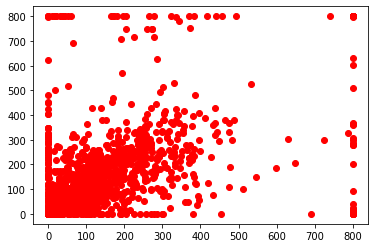

In [79]:
plt.scatter(y_test, y_pred, color='red')
plt.show()

## XG boost

In [122]:
xgb = xgboost.XGBRegressor()

In [123]:
y_train.head()

,value
id,
4914,29.0
18766,55.0
19647,16.0
9880,0.0
3059,25.0


In [124]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [125]:
y_pred2 = xgb.predict(X_test)

In [126]:
np.sqrt(mean_squared_error(y_test, y_pred2))

72.90348289812532

# Conclusion

Gradient boosting machine > Random Forest > Decision Tree

1. Decision Tree: It breaks down a dataset into smaller and smaller subsets.The model is really simple to understand. But I noticed it is having a big disadvantage which is "overfitting".
2. Random Forest: A collection of decision trees with a single, aggregated result. What I like from Random Forest is, it reduces overfitting problem in decision trees and also reduces the variance. Therefore, accuracy was higher.
3. Gradient boosting machine: It seemed so flexible to work with any kind of data to me. Also like the random forest, it gives same accuracy score which is pretty high. I like it

## Exporting

In [59]:
test.shape

(4536, 23)

In [60]:
X.shape

(21157, 23)

In [127]:
final = regressor.predict(test)

In [128]:
final

array([144.,  22.,  19., ...,  34.,  34., 139.])

In [129]:
df = pd.DataFrame(final, columns = ['label'])

In [130]:
test = test.reset_index()

In [131]:
df.head()

,label
0,144.0
1,22.0
2,19.0
3,8.0
4,18.0


In [132]:
test.head()

,id,value1,value2,value3,temperature,humidity,pressure,visibility,temperature_1,humidity_1,...,visibility_1,visibility_2,visibility_3,pressure1,pressure2,pressure3,year,month,hour,day
0,21158,47.0,34.0,56.0,16.39,0.75,1010.4,16.093,-9.77,0.46,...,16.093,16.093,16.093,1025.7,1025.7,1025.7,2018,9,2,1
1,21159,23.0,47.0,34.0,17.70,0.69,1009.7,16.093,16.39,0.75,...,16.093,16.093,16.093,1010.4,1025.7,1025.7,2018,9,3,1
2,21160,20.0,23.0,47.0,18.50,0.65,1008.2,16.093,17.70,0.69,...,16.093,16.093,16.093,1009.7,1010.4,1025.7,2018,9,4,1
3,21161,17.0,20.0,23.0,18.97,0.61,1007.2,16.093,18.50,0.65,...,16.093,16.093,16.093,1008.2,1009.7,1010.4,2018,9,5,1
4,21162,5.0,17.0,20.0,19.11,0.60,1007.1,16.093,18.97,0.61,...,16.093,16.093,16.093,1007.2,1008.2,1009.7,2018,9,6,1


In [133]:
result = pd.merge(test['id'],
                  df['label'],
                  left_index = True,
                  right_index = True)

In [64]:
result.head()

,id,label
0,21158,68.13032
1,21159,53.77568
2,21160,45.23216
3,21161,17.27524
4,21162,10.61140


In [134]:
result.to_csv("8:36PM.csv", 
              index = None, 
              sep = ",",
              header = True)